In [14]:
import sys, os

import numpy as np
from numpy import expand_dims

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import pandas as pd

import pylab as pl

In [43]:
# The way tensorflow is imported might be changed to work with gpus
import tensorflow as tf

import keras
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adadelta
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, AveragePooling2D
    

In [3]:
def pad_image(image, max_size = (25,25)):
    """
    Simply pad an image with zeros up to max_size.
    """
    size = np.shape(image)
    px, py = (max_size[0]-size[0]), (max_size[1]-size[1])
    a1=int(np.floor(px/2.0))
    a2=int(np.ceil(px/2.0))
    a3=int(np.floor(py/2.0))
    a4=int(np.ceil(py/2.0))
    image = np.pad(image, ((a1, a2), (a3, a4)), 'constant', constant_values=(0))
    #image = np.pad(image, (map(int,((np.floor(px/2.), np.ceil(px/2.)))), map(int,(np.floor(py/2.), np.ceil(py/2.)))), 'constant')
    return image


def normalize(histo, multi=255):
    """
    Normalize picture in [0,multi] range, with integer steps. E.g. multi=255 for 256 steps.
    """
    return (histo/np.max(histo)*multi).astype(int)

In [6]:
#Number events for each set of data
NUMBER_EVENTS = 40000

NUMBER_TRAIN = 50000
BATCH_SIZE = 32
EPOCHS = 50

In [4]:
notebook_path = os.path.abspath("CNN_for_jettagging.ipynb")

qcd_file_path = os.path.join(os.path.dirname(notebook_path), "qcd_leading_jet.npz")
top_file_path = os.path.join(os.path.dirname(notebook_path), "top_leading_jet.npz")

qcd_npz_file = np.load(qcd_file_path, allow_pickle=True, encoding='bytes')
top_npz_file = np.load(top_file_path, allow_pickle=True, encoding='bytes')

qcd_data = qcd_npz_file['arr_0']
top_data = top_npz_file['arr_0']

In [7]:
print("qcd data shape: ", qcd_data.shape)
print("top data shape: ",top_data.shape)

#Added automation to slecting N events 
#+1 as np deletes up to and not including upper limit
qcd_number_to_remove = (qcd_data.shape[0] - NUMBER_EVENTS) + 1
top_number_to_remove = (top_data.shape[0] - NUMBER_EVENTS) + 1

#Pick the N events 
qcd_data = np.delete(qcd_data ,np.s_[1:qcd_number_to_remove],0)
top_data = np.delete(top_data ,np.s_[1:top_number_to_remove],0)

print('We have {} QCD jets and {} top jets'.format(len(qcd_data), len(top_data)))

qcd data shape:  (60713,)
top data shape:  (61761,)
We have 40000 QCD jets and 40000 top jets


In [8]:
# pad and normalize images
x_data_qcd = list(map(pad_image, qcd_data))
x_data_top = list(map(pad_image, top_data))

x_data_qcd = list(map(normalize, x_data_qcd))
x_data_top = list(map(normalize, x_data_top))

In [16]:
etaran=(0, 25)
phiran=(0, 25)
vmin=1e-3
vmax=5000
extent = phiran + etaran

av_array=np.mean(x_data_qcd, axis=0)

fig = pl.figure(figsize=[5,5])
ax = fig.gca()
im = ax.imshow(av_array, interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax), extent=extent,
               cmap='nipy_spectral')
cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
plt.title("QCD Jets")
fig.savefig(os.path.join(os.path.dirname(notebook_path), "qcdc_av.png"))
plt.close(fig)

In [17]:
av_array1=np.mean(x_data_top, axis=0)

fig = pl.figure(figsize=[5,5])
ax = fig.gca()
im = ax.imshow(av_array1, interpolation='nearest', norm=LogNorm(vmin=vmin, vmax=vmax), extent=extent,
               cmap='nipy_spectral')
cbar = plt.colorbar(im, fraction=0.05, pad=0.05)
plt.title("Top Jets")
fig.savefig(os.path.join(os.path.dirname(notebook_path), "top_av.png"))
plt.close(fig)

In [8]:
# objects and labels
x_data = np.concatenate((x_data_qcd, x_data_top))
y_data = np.array([0]*len(x_data_qcd)+[1]*len(x_data_top))


print("xdatashape",x_data.shape)

x_data = list(x_data)

xdatashape (80000,)


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [11]:
# shapeuffle
np.random.seed(0) # for reproducibility
x_data, y_data = np.random.permutation(np.array([x_data, y_data]).T).T


# the data coming out of previous commands is a list of 2D arrays. We want a 3D np array (n_events, xpixels, ypixels)
x_data = np.stack(x_data)

print("xshape-after stack",x_data.shape)

x_data = expand_dims(x_data, axis=3)
y_data = keras.utils.to_categorical(y_data, 2)

C:\Users\v76807lg\AppData\Local\Temp\ipykernel_5444\2070534313.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_data, y_data = np.random.permutation(np.array([x_data, y_data]).T).T


xshape-after stack (80000, 25, 25)


In [12]:
(x_train, x_test) = x_data[:NUMBER_TRAIN], x_data[NUMBER_TRAIN:]
(y_train, y_test) = y_data[:NUMBER_TRAIN], y_data[NUMBER_TRAIN:]

In [34]:
# start with a small CNN
# this uses max pooling which makes with the MNIST data set as there is high contrast but we have a much finer structure
# to our data. Hence, try average pooling. Max pooling is getting max accuracy of 0.867
cnn_tagging_model = Sequential()
cnn_tagging_model.add(Conv2D(8, (3, 3), activation='relu', input_shape=(25, 25)))
# cnn_tagging_model.add(MaxPooling2D((3, 3)))
cnn_tagging_model.add(AveragePooling2D((3, 3)))
cnn_tagging_model.add(Conv2D(16, (3, 3), activation='relu'))
# cnn_tagging_model.add(MaxPooling2D((2, 2)))
cnn_tagging_model.add(AveragePooling2D((2, 2)))
cnn_tagging_model.add(Flatten())
cnn_tagging_model.add(Dense(2, activation='softmax'))

In [39]:
# trying model from research paper 
cnn_tagging_model = Sequential()
cnn_tagging_model.add(Conv2D(8, (4, 4), activation='relu', input_shape=(25, 25, 1)))
cnn_tagging_model.add(Conv2D(8, (4, 4), activation='relu'))
cnn_tagging_model.add(MaxPooling2D((2, 2)))
cnn_tagging_model.add(Conv2D(8, (4, 4), activation='relu'))
cnn_tagging_model.add(Conv2D(8, (4, 4), activation='relu'))
cnn_tagging_model.add(MaxPooling2D((2, 2)))                     
cnn_tagging_model.add(Flatten())
cnn_tagging_model.add(Dense(2, activation='softmax'))


In [44]:
optimizer = Adadelta(learning_rate=0.3)

cnn_tagging_model.compile(loss='binary_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
cnn_tagging_model.summary()

save_path = qcd_file_path = os.path.join(os.path.dirname(notebook_path), "cnn_tagging_model.tf")
cnn_tagging_model.save_weights(save_path)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 22, 22, 8)         136       
                                                                 
 conv2d_9 (Conv2D)           (None, 19, 19, 8)         1032      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 9, 9, 8)          0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 6, 6, 8)           1032      
                                                                 
 conv2d_11 (Conv2D)          (None, 3, 3, 8)           1032      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 1, 1, 8)          0         
 2D)                                                  

In [45]:
history = cnn_tagging_model.fit(x_train, y_train,
                       batch_size=BATCH_SIZE, 
                       epochs=3*EPOCHS,
                       verbose=2,
                       validation_data=(x_test, y_test))

Epoch 1/150
1563/1563 - 11s - loss: 0.4266 - accuracy: 0.8622 - val_loss: 0.3359 - val_accuracy: 0.8632 - 11s/epoch - 7ms/step
Epoch 2/150
1563/1563 - 10s - loss: 0.3114 - accuracy: 0.8730 - val_loss: 0.3211 - val_accuracy: 0.8682 - 10s/epoch - 6ms/step
Epoch 3/150
1563/1563 - 10s - loss: 0.3014 - accuracy: 0.8761 - val_loss: 0.3168 - val_accuracy: 0.8686 - 10s/epoch - 7ms/step
Epoch 4/150
1563/1563 - 10s - loss: 0.2961 - accuracy: 0.8772 - val_loss: 0.3169 - val_accuracy: 0.8689 - 10s/epoch - 7ms/step
Epoch 5/150
1563/1563 - 10s - loss: 0.2922 - accuracy: 0.8789 - val_loss: 0.3268 - val_accuracy: 0.8629 - 10s/epoch - 6ms/step
Epoch 6/150
1563/1563 - 10s - loss: 0.2895 - accuracy: 0.8786 - val_loss: 0.3171 - val_accuracy: 0.8699 - 10s/epoch - 7ms/step
Epoch 7/150
1563/1563 - 10s - loss: 0.2878 - accuracy: 0.8803 - val_loss: 0.3135 - val_accuracy: 0.8723 - 10s/epoch - 6ms/step
Epoch 8/150
1563/1563 - 10s - loss: 0.2867 - accuracy: 0.8800 - val_loss: 0.3154 - val_accuracy: 0.8699 - 10s/e

1563/1563 - 10s - loss: 0.2713 - accuracy: 0.8882 - val_loss: 0.3149 - val_accuracy: 0.8709 - 10s/epoch - 7ms/step
Epoch 66/150
1563/1563 - 10s - loss: 0.2716 - accuracy: 0.8874 - val_loss: 0.3097 - val_accuracy: 0.8728 - 10s/epoch - 7ms/step
Epoch 67/150
1563/1563 - 10s - loss: 0.2712 - accuracy: 0.8876 - val_loss: 0.3106 - val_accuracy: 0.8728 - 10s/epoch - 7ms/step
Epoch 68/150
1563/1563 - 10s - loss: 0.2713 - accuracy: 0.8875 - val_loss: 0.3112 - val_accuracy: 0.8732 - 10s/epoch - 6ms/step
Epoch 69/150
1563/1563 - 11s - loss: 0.2709 - accuracy: 0.8877 - val_loss: 0.3137 - val_accuracy: 0.8693 - 11s/epoch - 7ms/step
Epoch 70/150
1563/1563 - 10s - loss: 0.2706 - accuracy: 0.8881 - val_loss: 0.3091 - val_accuracy: 0.8724 - 10s/epoch - 7ms/step
Epoch 71/150
1563/1563 - 11s - loss: 0.2698 - accuracy: 0.8882 - val_loss: 0.3239 - val_accuracy: 0.8731 - 11s/epoch - 7ms/step
Epoch 72/150
1563/1563 - 11s - loss: 0.2701 - accuracy: 0.8879 - val_loss: 0.3122 - val_accuracy: 0.8725 - 11s/epoch 

Epoch 129/150
1563/1563 - 10s - loss: 0.2636 - accuracy: 0.8914 - val_loss: 0.3219 - val_accuracy: 0.8721 - 10s/epoch - 7ms/step
Epoch 130/150
1563/1563 - 11s - loss: 0.2635 - accuracy: 0.8917 - val_loss: 0.3300 - val_accuracy: 0.8670 - 11s/epoch - 7ms/step
Epoch 131/150
1563/1563 - 11s - loss: 0.2631 - accuracy: 0.8927 - val_loss: 0.3165 - val_accuracy: 0.8713 - 11s/epoch - 7ms/step
Epoch 132/150
1563/1563 - 10s - loss: 0.2637 - accuracy: 0.8917 - val_loss: 0.3144 - val_accuracy: 0.8723 - 10s/epoch - 7ms/step
Epoch 133/150
1563/1563 - 11s - loss: 0.2633 - accuracy: 0.8909 - val_loss: 0.3212 - val_accuracy: 0.8718 - 11s/epoch - 7ms/step
Epoch 134/150
1563/1563 - 11s - loss: 0.2631 - accuracy: 0.8917 - val_loss: 0.3237 - val_accuracy: 0.8681 - 11s/epoch - 7ms/step
Epoch 135/150
1563/1563 - 11s - loss: 0.2628 - accuracy: 0.8926 - val_loss: 0.3207 - val_accuracy: 0.8724 - 11s/epoch - 7ms/step
Epoch 136/150
1563/1563 - 11s - loss: 0.2628 - accuracy: 0.8922 - val_loss: 0.3245 - val_accuracy

In [46]:
def histplot(history, save_name):
    hist = pd.DataFrame(history.history)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    hist.plot(y=['loss', 'val_loss'], ax=ax1)
    min_loss = hist['val_loss'].min()
    ax1.hlines(min_loss, 0, len(hist), linestyle='dotted',
               label='min(val_loss) = {:.3f}'.format(min_loss))
    ax1.legend(loc='upper right')
    hist.plot(y=['accuracy', 'val_accuracy'], ax=ax2)
    max_acc = hist['val_accuracy'].max()
    ax2.hlines(max_acc, 0, len(hist), linestyle='dotted',
               label='max(val_accuracy) = {:.3f}'.format(max_acc))
    ax2.legend(loc='lower right', fontsize='large')
    fig.savefig(os.path.join(os.path.dirname(notebook_path), save_name + ".png"))

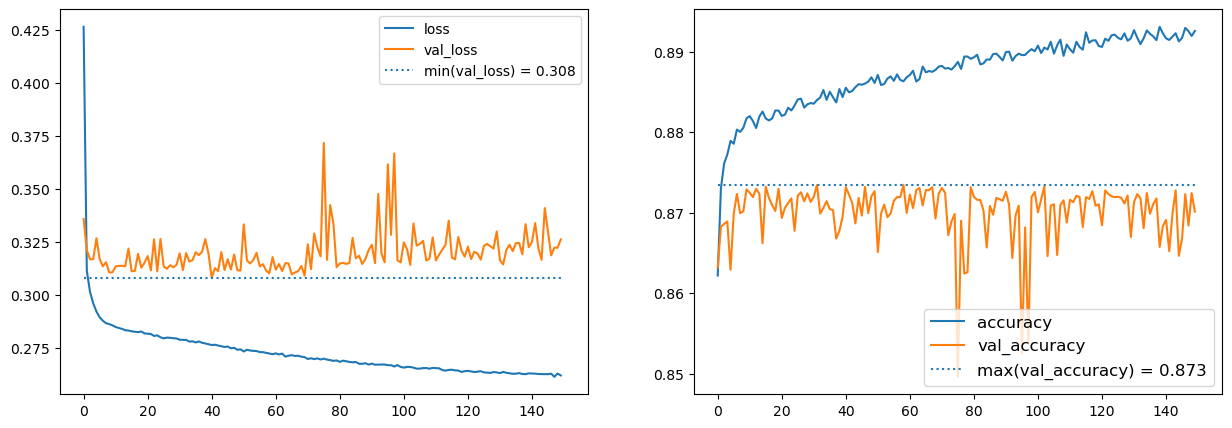

In [47]:
histplot(history, "research_paper_model")